In [18]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
import importlib
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MLP, SetStyle, HistRoutine, net, PET, omnifold_acceptance_efficieny
#from omnifold.net import weighted_binary_crossentropy
#import energyflow as ef

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="2" #odslserv 0123 überprüfen
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="3"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#truth_data = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/files_josef/truth_ttbar_enhanced.Nominal.root'
#herwig_data = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/files_josef/ttbar_enhanced_Herwig71_fast.Nominal.root'
#pythia_data = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/files_josef/ttbar_enhanced.Nominal.root'

#truth_file = uproot.open(truth_data)
#truth_tree = truth_file['NOSYS/physics'] # particle level quantities after particle level cuts

#herwig_file = uproot.open(herwig_data)
#herwig_tree = herwig_file['NOSYS/Whad_particle'] #check with Daniel if cuts are needed

#pythia_file = uproot.open(pythia_data)
#pythia_tree_matched = pythia_file['NOSYS/matched_Whad_particle'] # particle & reco level quantities after both cuts
#pythia_tree_reco = pythia_file['NOSYS/Whad_particle'] # particle & reco level quantities after reco cuts
#
#truth_array = truth_tree.arrays()
#herwig_array = herwig_tree.arrays()
#pythia_array_reco_cuts = pythia_tree_reco.arrays()
#pythia_array_matched_cuts = pythia_tree_matched.arrays()
#final_df.to_pickle("final_pythia_array")
#herwig_df.to_pickle("herwig_array")

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_herwig_ttbar.pkl')
#data_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_data.pkl')
pythia_df["w2"] = pythia_df['eventWeight'].to_numpy()*pythia_df['eventWeight'].to_numpy()
herwig_df["w2"] = herwig_df['eventWeight'].to_numpy()*herwig_df['eventWeight'].to_numpy()
#data_df.fillna(0.0, inplace=True)

In [3]:
def MC_data_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    truth_pts  = [df[f'truth_pt{p}']   for p in particle_names]
    truth_etas = [df[f'truth_eta{p}']  for p in particle_names]
    truth_phis = [df[f'truth_phi{p}']  for p in particle_names]
    
    truth_masses = [np.zeros_like(df['truth_ptl1'])] + \
                   [df[f'truth_mb{i}'] for i in range(1, 5)] + \
                   [df[f'truth_mj{i}'] for i in range(1, 7)]

    truth_features = np.stack([truth_pts, truth_etas, truth_phis, truth_masses], axis=-1)
    truth_features = truth_features.transpose(1, 0, 2)

    # Neutrino (truth): use 'truth_met' and 'truth_met_phi'
    truth_met_pt = df['truth_met']
    truth_met_phi = df['truth_metphi']
    zeros_truth = np.zeros_like(truth_met_pt)
    neutrino_truth = np.stack([truth_met_pt, zeros_truth, truth_met_phi, zeros_truth], axis=-1)

    truth_features = np.concatenate([truth_features, neutrino_truth[:, None, :]], axis=1)
    
    return reco_features, truth_features

def DATA_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    
    return reco_features

In [4]:
pythia_reco, pythia_truth = MC_data_shaper(pythia_df)
herwig_reco, herwig_truth = MC_data_shaper(herwig_df)

pythia_weights = pythia_df['eventWeight'].to_numpy()
herwig_weights = herwig_df['eventWeight'].to_numpy()

pythia_pass_reco = pythia_df['pass_reco'].to_numpy()
pythia_pass_gen = pythia_df['pass_particle'].to_numpy()
herwig_pass_reco = herwig_df['pass_reco'].to_numpy()
herwig_pass_gen = herwig_df['pass_particle'].to_numpy()

In [5]:
all_indices_pythia = np.arange(len(pythia_reco))
np.random.seed(42)  # reproducibility
np.random.shuffle(all_indices_pythia)

# First random sample
random_indices_pythia_1 = all_indices_pythia[:1_000_000]
# Second, independent (non-overlapping) sample
random_indices_pythia_2 = all_indices_pythia[1_000_000:2_000_000]

# First Pythia sample
pythia_reco_train    = pythia_reco[random_indices_pythia_1]
pythia_truth_train   = pythia_truth[random_indices_pythia_1]
pythia_weights_train = pythia_weights[random_indices_pythia_1]
pythia_pass_reco_train = pythia_pass_reco[random_indices_pythia_1]
pythia_pass_gen_train = pythia_pass_gen[random_indices_pythia_1]

# Second Pythia sample
pythia_reco_test    = pythia_reco[random_indices_pythia_2]
pythia_truth_test   = pythia_truth[random_indices_pythia_2]
pythia_weights_test = pythia_weights[random_indices_pythia_2]
pythia_pass_reco_test = pythia_pass_reco[random_indices_pythia_2]
pythia_pass_gen_test = pythia_pass_gen[random_indices_pythia_2]

# First Herwig sample
random_indices_herwig = np.random.choice(len(herwig_reco), size=1_000_000, replace=False)
herwig_reco_train   = herwig_reco[random_indices_herwig]
herwig_truth_train   = herwig_truth[random_indices_herwig]
herwig_weights_train = herwig_weights[random_indices_herwig]
herwig_pass_reco_train = herwig_pass_reco[random_indices_herwig]
herwig_pass_gen_train = herwig_pass_gen[random_indices_herwig]

In [6]:
herwig_loader = DataLoader(reco = herwig_reco_train, gen = herwig_truth_train, weight = herwig_weights_train,
                           pass_reco = herwig_pass_reco_train, pass_gen = herwig_pass_gen_train,
                           normalize=True, normalization_factor = np.sum(herwig_weights_train))

pythia_loader = DataLoader(reco = pythia_reco_train, gen = pythia_truth_train, weight = pythia_weights_train,
                           pass_reco = pythia_pass_reco_train, pass_gen = pythia_pass_gen_train,
                           normalize=True, normalization_factor = np.sum(pythia_weights_train))

INFO: Normalizing sum of weights to 173218.59375 ...
INFO: Normalizing sum of weights to 59506.36328125 ...


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

class MaskedAveragePooling(layers.Layer):
    def call(self, x, mask):
        # x: (batch, seq_len, features)
        # mask: (batch, seq_len), dtype bool
        mask = tf.cast(mask, tf.float32)[..., tf.newaxis]  # (batch, seq_len, 1)
        x = x * mask
        return tf.reduce_sum(x, axis=1) / tf.reduce_sum(mask, axis=1)

class ParticleMaskLayer(layers.Layer):
    def call(self, x):
        return tf.reduce_any(tf.not_equal(x, 0), axis=-1)  # shape: (batch, seq)

def build_transformer_model(input_shape=(12, 4),
                            num_heads=4,
                            ff_dim=64,
                            num_transformer_blocks=2,
                            dropout_rate=0.1):

    inputs = Input(shape=input_shape)

    # Get attention mask: True where not padded
    mask = ParticleMaskLayer()(inputs)  # shape: (batch, 11)

    # Learned positional embedding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_embed = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = inputs + pos_embed  # broadcasting position embedding

    for _ in range(num_transformer_blocks):
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=input_shape[1]
        )(x, x, attention_mask=mask[:, tf.newaxis, :])  # shape: (batch, 1, 11)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        ff_output = layers.Dense(ff_dim, activation='relu')(x)
        ff_output = layers.Dense(input_shape[1])(ff_output)
        ff_output = layers.Dropout(dropout_rate)(ff_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Use masked average pooling instead of GlobalAveragePooling1D
    x = MaskedAveragePooling()(x, mask)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

In [8]:
model1 = build_transformer_model()
model2 = build_transformer_model()

I0000 00:00:1759388533.875135 2168618 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 140838 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:43:00.0, compute capability: 9.0


In [19]:
importlib.reload(omnifold_acceptance_efficieny)

Horovod not found, will continue with single only GPUs.


<module 'omnifold.omnifold_acceptance_efficieny' from '/scratch/mjosef/Unfolding/omnifold/omnifold/omnifold_acceptance_efficieny.py'>

In [20]:
omnifold = omnifold_acceptance_efficieny.MultiFold(
    "Acceptance_Corrections_WWbb",
    model1,
    model2,
    herwig_loader,
    pythia_loader,
    batch_size = 128,
    niter = 4,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = 'acceptance_corrections_WWbb',
    verbose = True,
    lr = 1e-5,
    early_stop=5,
    n_ensemble=1,
)

15625 training steps at reco and 15625 steps at gen


In [21]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1A
Creating cached data from step 1
################################################################################
Train events used: 33431, Test events used: 8358
################################################################################
Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0416 - val_loss: 0.0417 - learning_rate: 1.0000e-05
Epoch 2/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0414 - val_loss: 0.0414 - learning_rate: 1.0000e-05
Epoch 3/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0416 - val_loss: 0.0412 - learning_rate: 1.0000e-05
Epoch 4/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0409 - val_loss: 0.0411 - learning_rate: 1.0000e-05
Epoch 5/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0409 - val_loss: 0.0409 - learning_rate: 1.0000e-05
Epoch 6/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0403 - val_loss: 0.0408 - learning_rate: 1.0000e-05
Epoch 7/100
208/208 ━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
unfolded_weights  = omnifold.reweight(pythia_truth_test,omnifold.model2,batch_size=1000)

In [ ]:
np.save('/scratch/mjosef/Unfolding/omnifold/acceptance_corrections_WWbb/unfolded_weights.npy', unfolded_weights)

In [ ]:
#unfolded_weights = np.load("weights_transformer_acceptance_corrections/unfolded_weights.npy")

In [ ]:
import pickle
import os
# Set these to your parameters
weights_folder = 'acceptance_corrections_WWbb'     # folder where your weights/pkl are saved
name = "Acceptance_Corrections_WWbb"     # your MultiFold.name
niter = 4                        # number of iterations
n_ensemble = 1                   # number of ensembles per step
# Loop over iterations and steps
for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            # Construct pickle file name
            model_file = f"{weights_folder}/OmniFold_{name}_iter{iteration}_step{stepn}"
            if n_ensemble > 1:
                model_file += f"_ensemble{e}"
            model_file += ".weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            # Load history
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
            else:
                print(f"History file not found: {history_file}")

        # Average over ensembles if multiple
        avg_loss = np.mean(all_loss, axis=0)
        avg_val_loss = np.mean(all_val_loss, axis=0)

        plt.plot(avg_loss, label='Training loss')
        plt.plot(avg_val_loss, label='Validation loss')
        plt.legend()
        plt.grid(True)
        plt.show()


In [ ]:
abc = np.load("weights_transformer_acceptance_corrections/unfolded_weights.npy")

/scratch/mjosef/Unfolding/omnifold/omnifold/utils.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(9, 9))


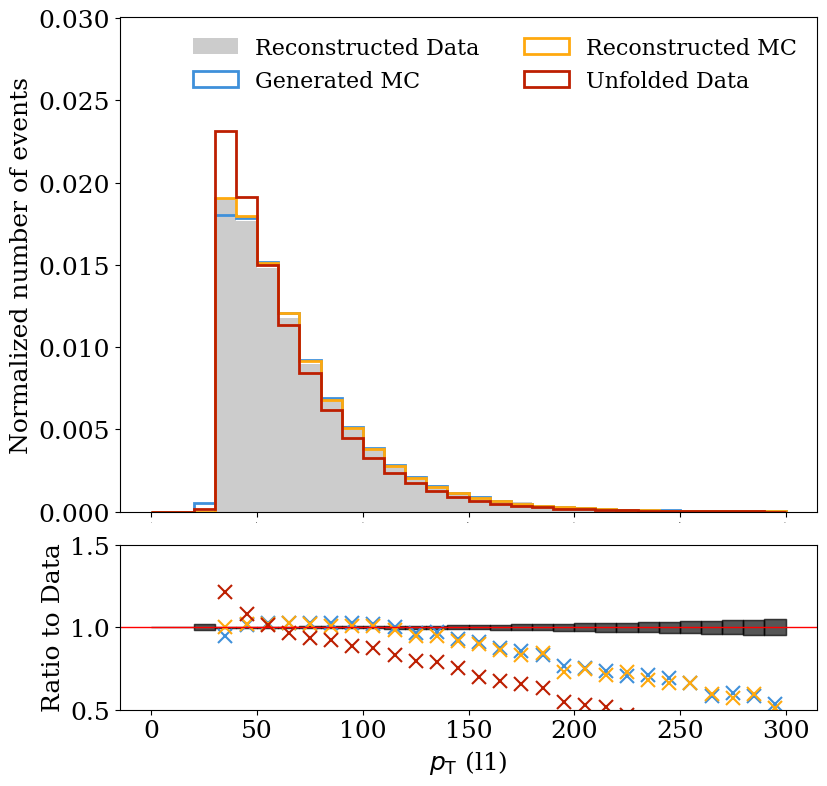

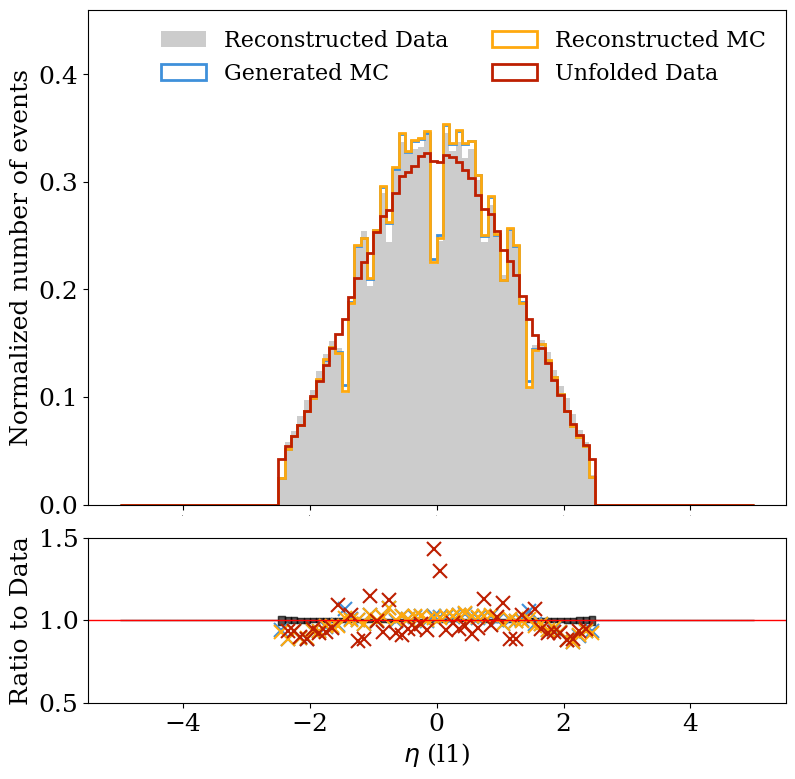

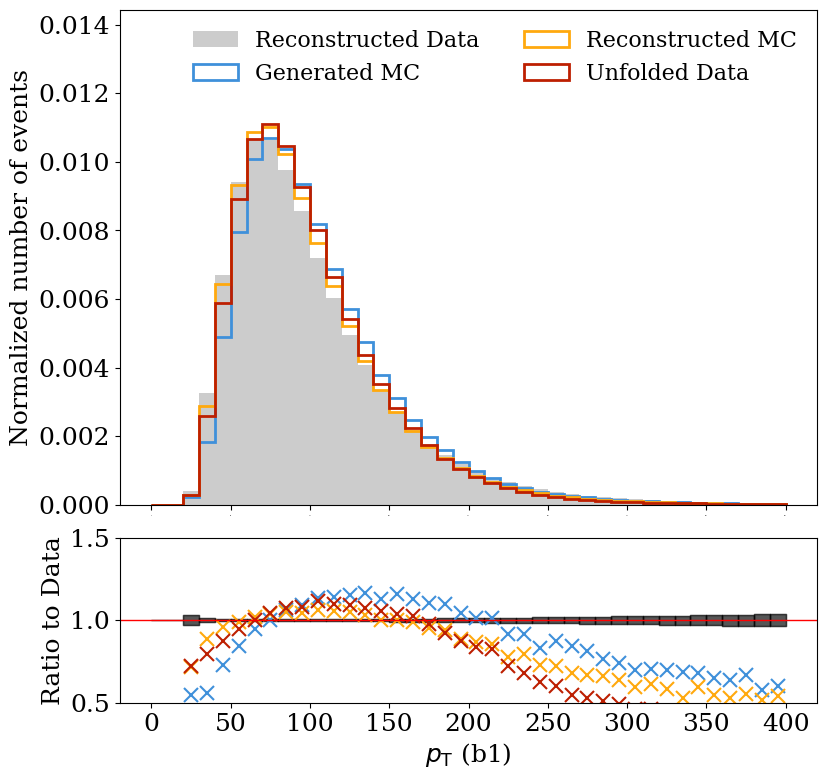

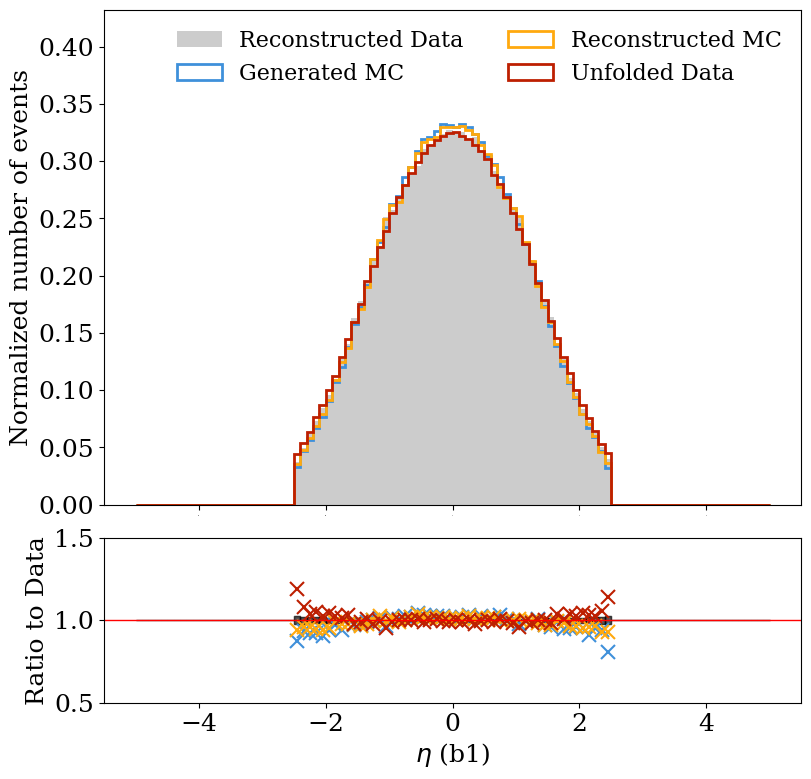

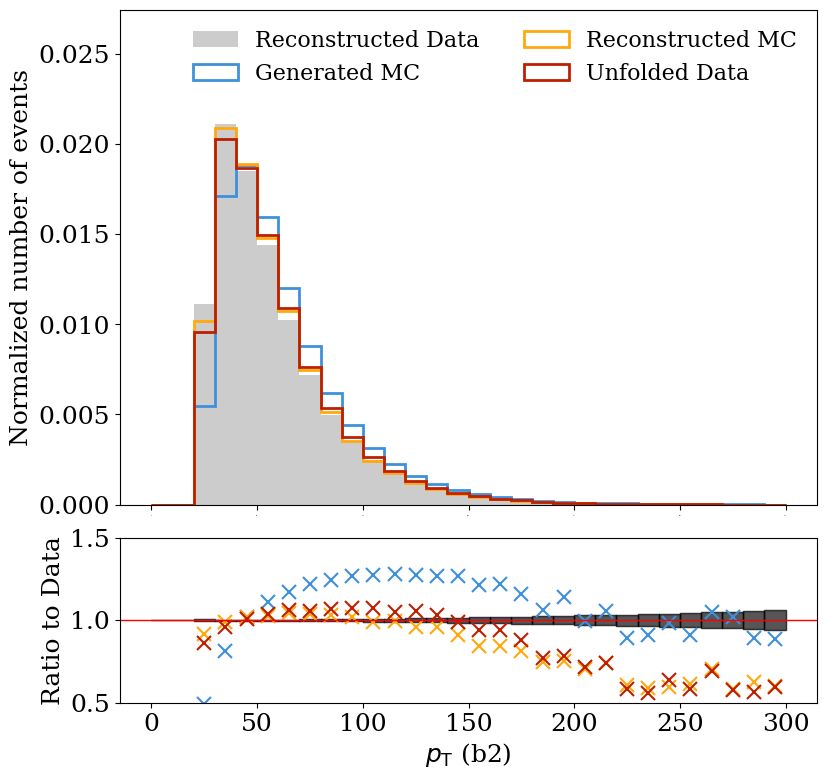

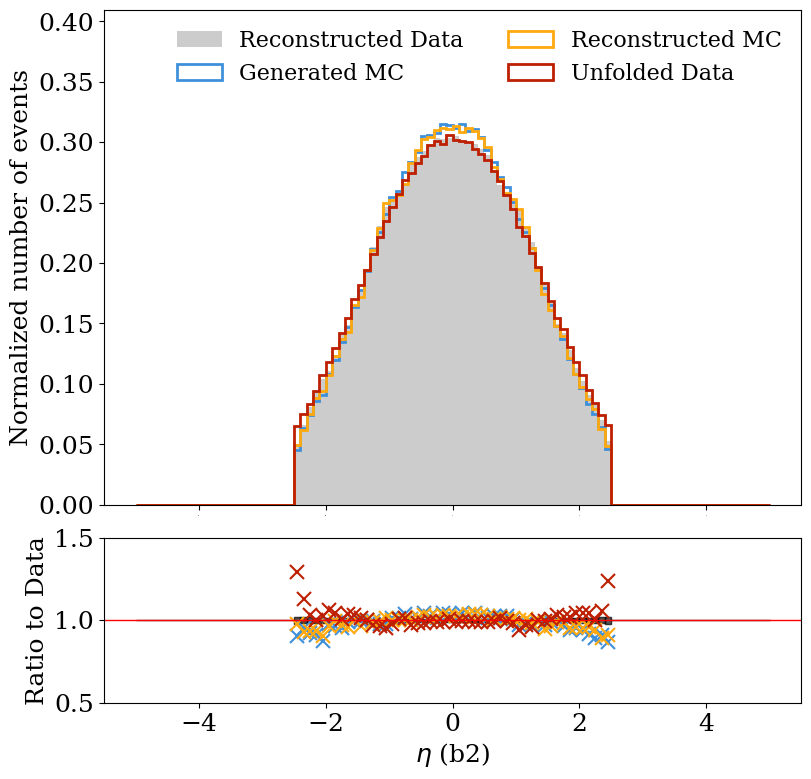

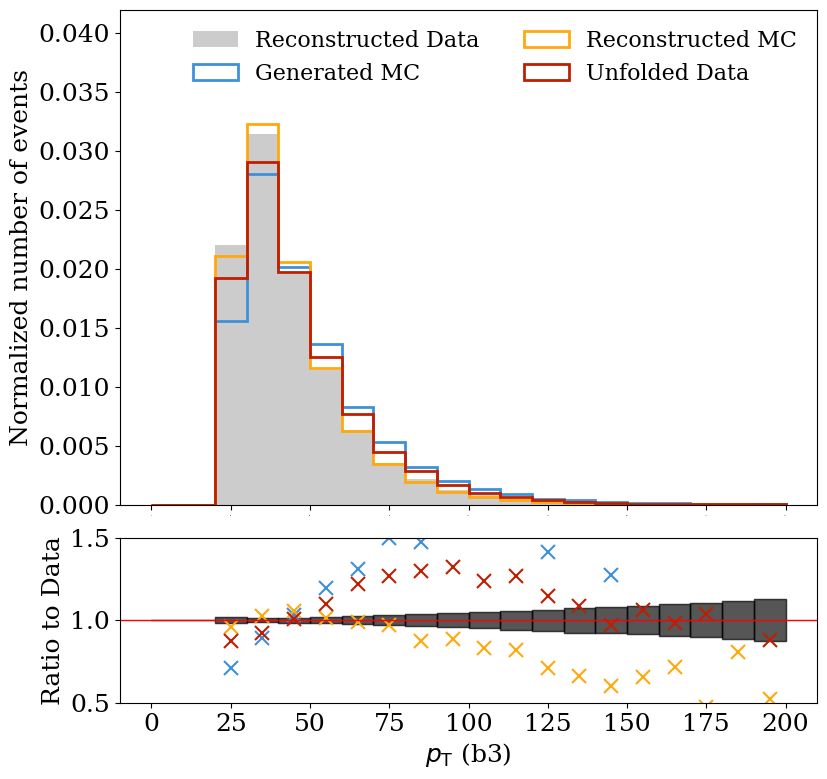

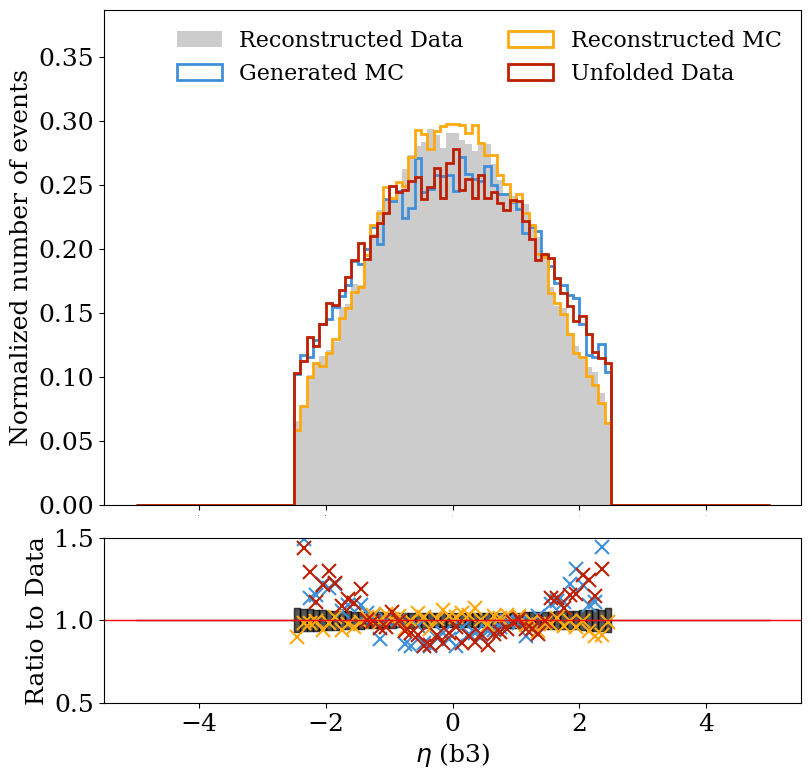

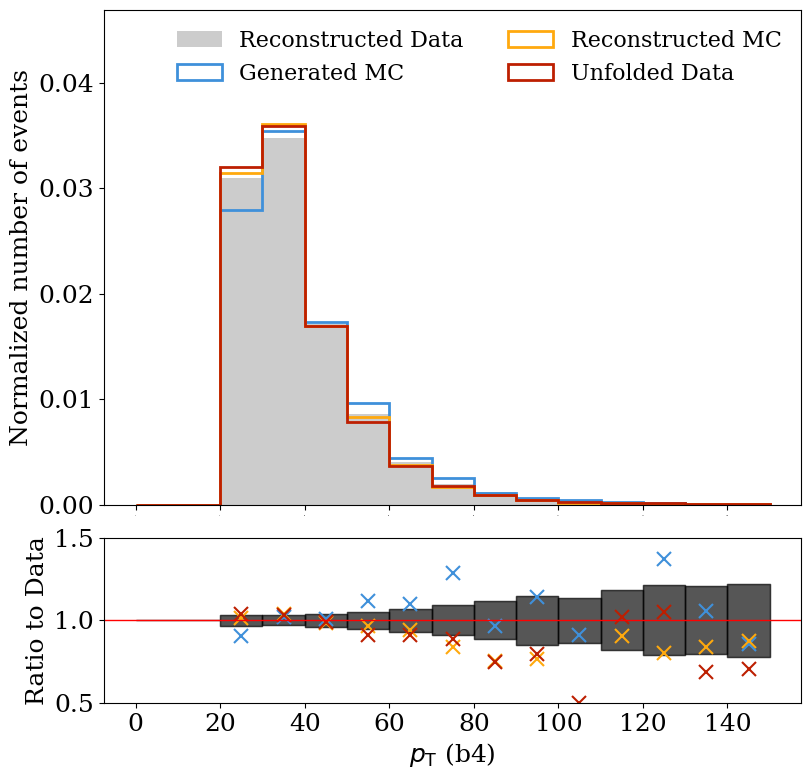

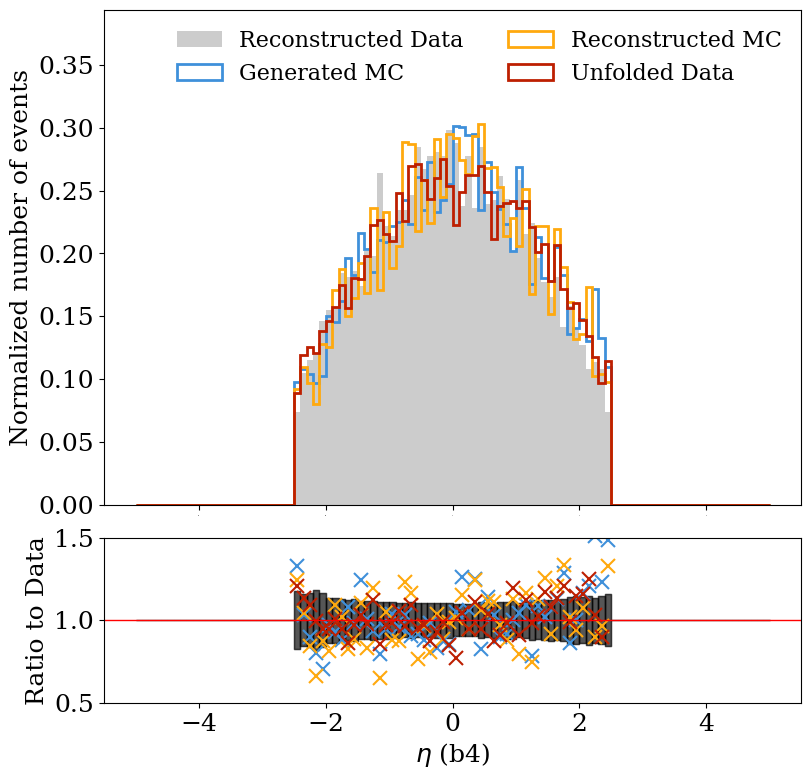

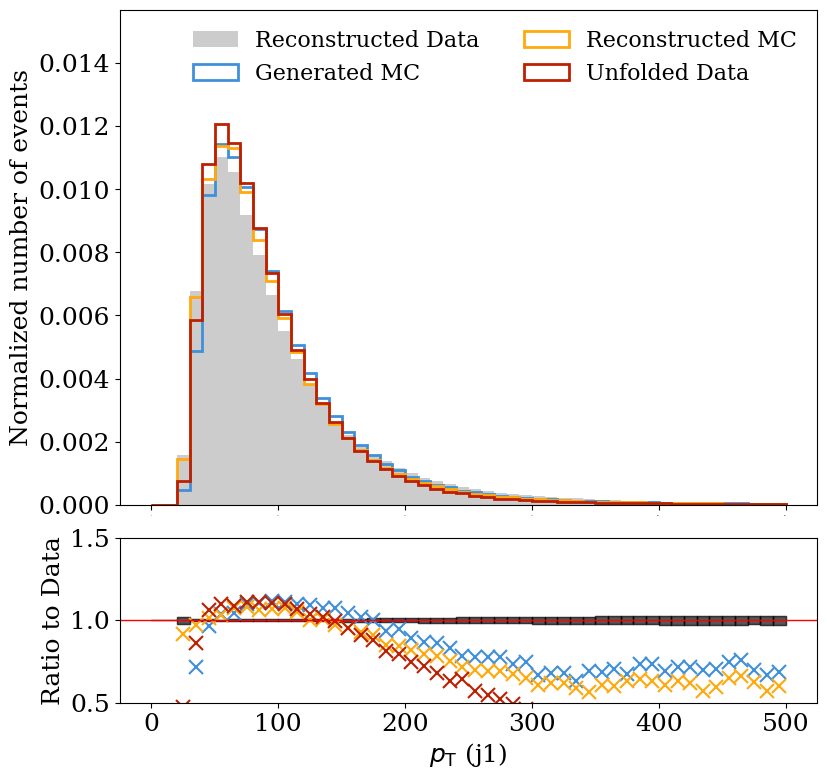

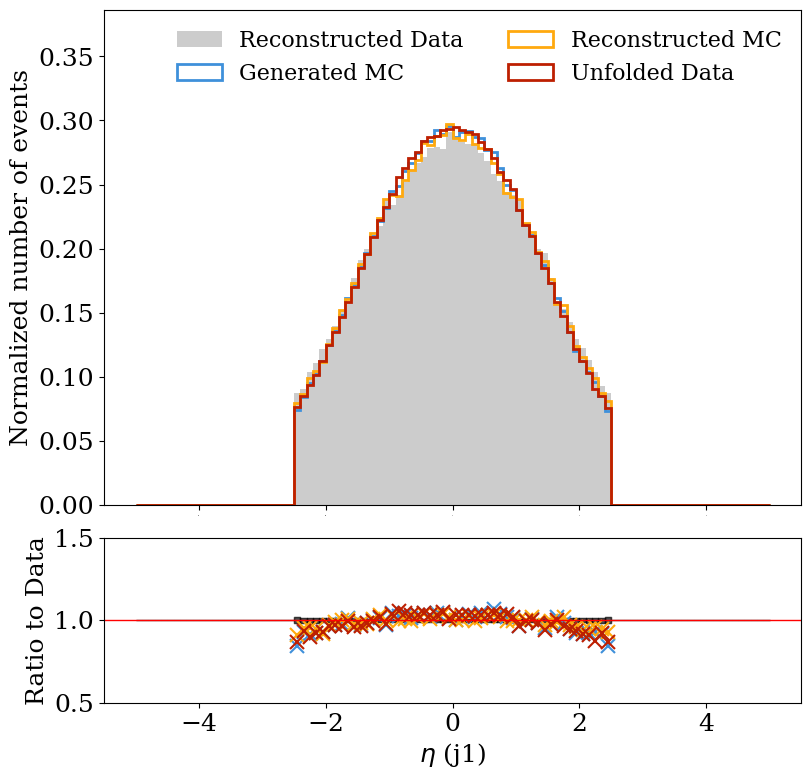

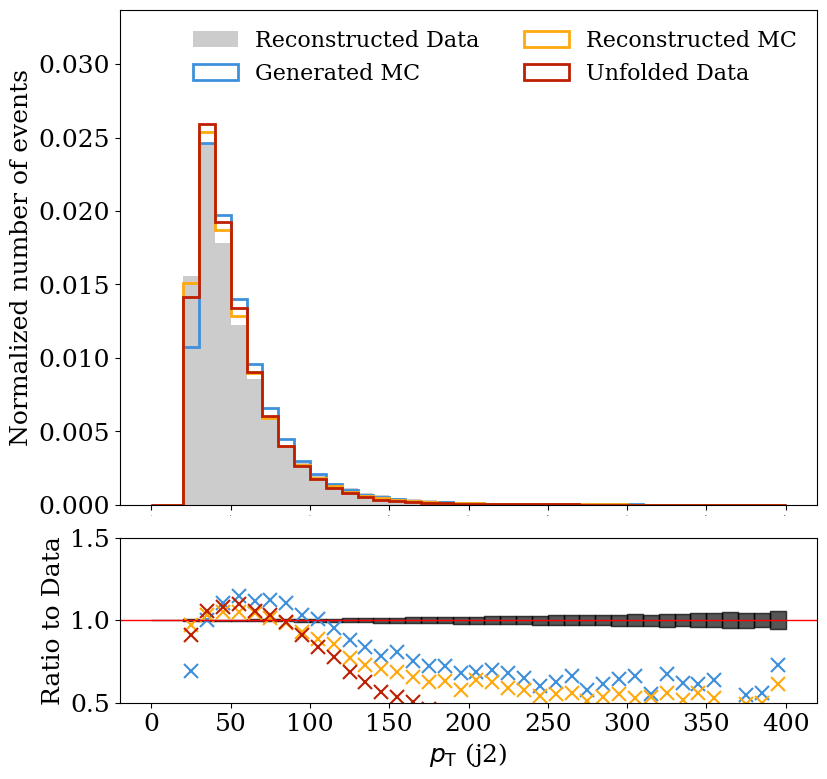

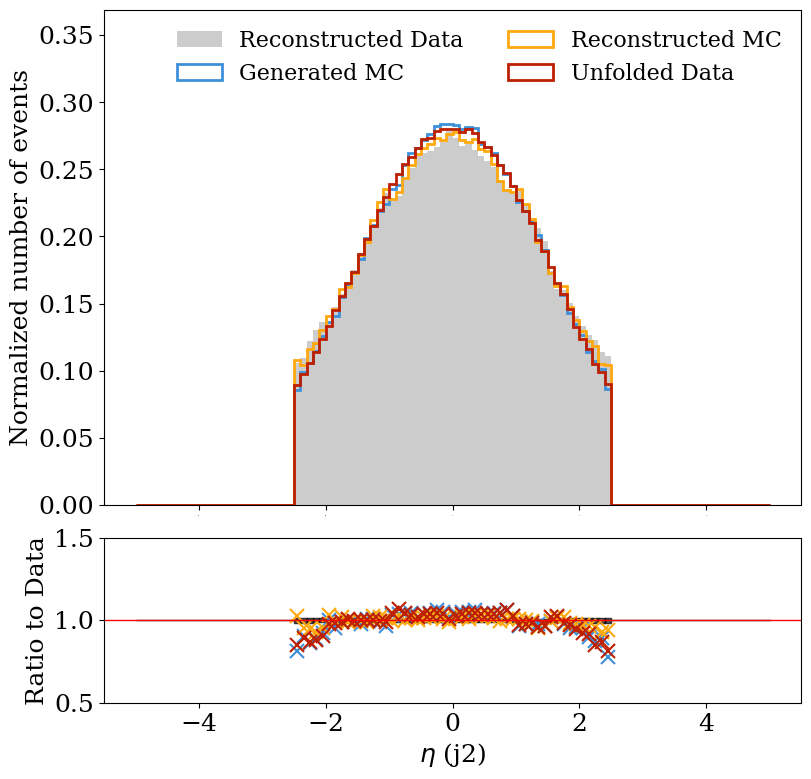

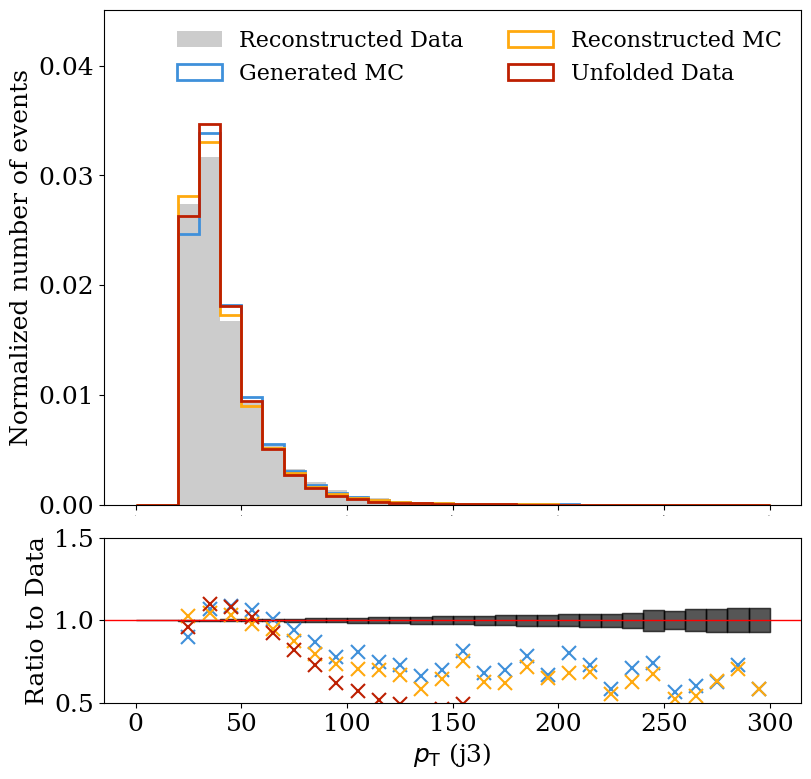

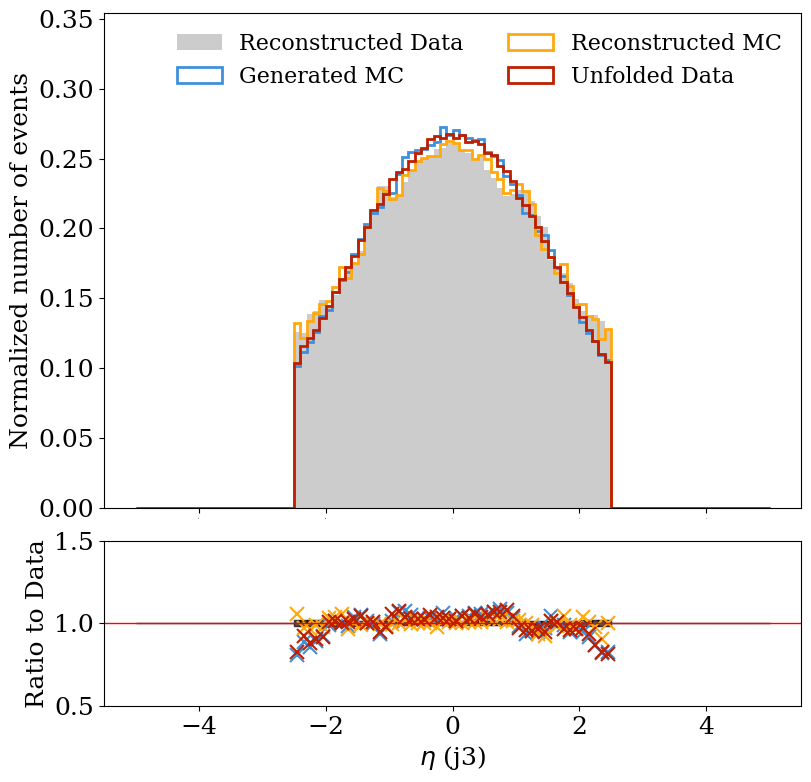

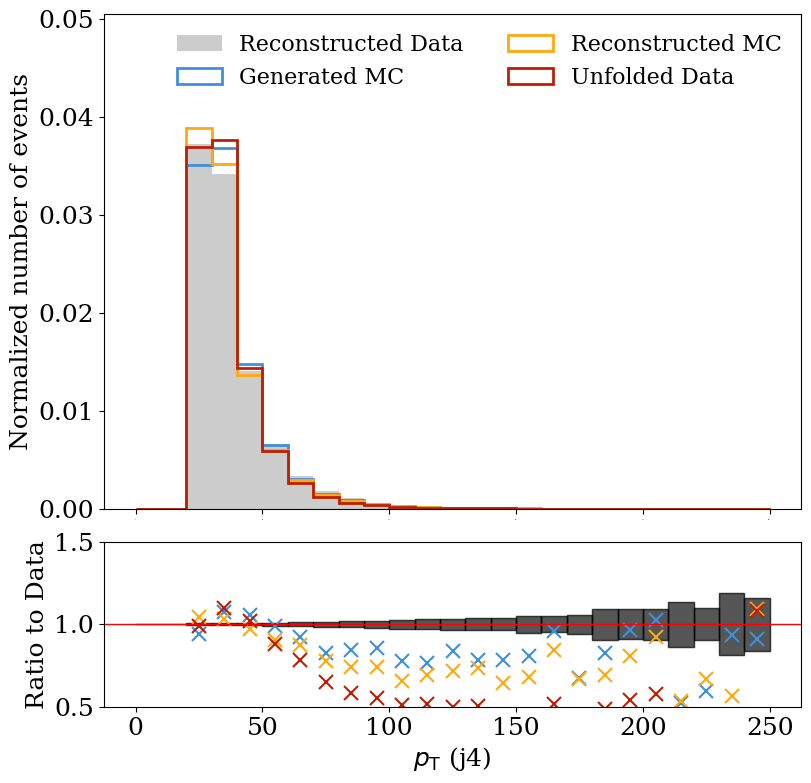

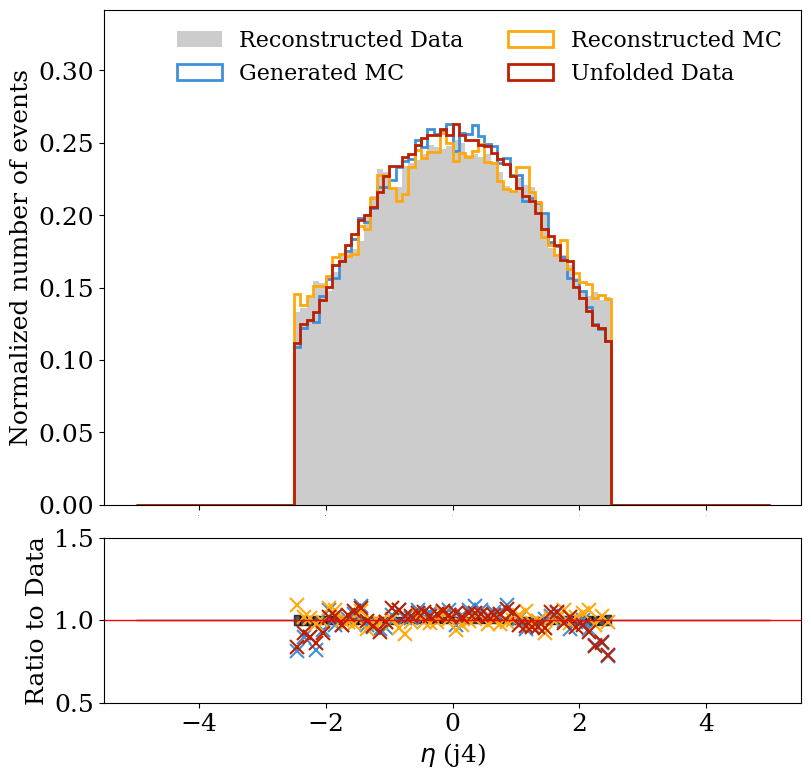

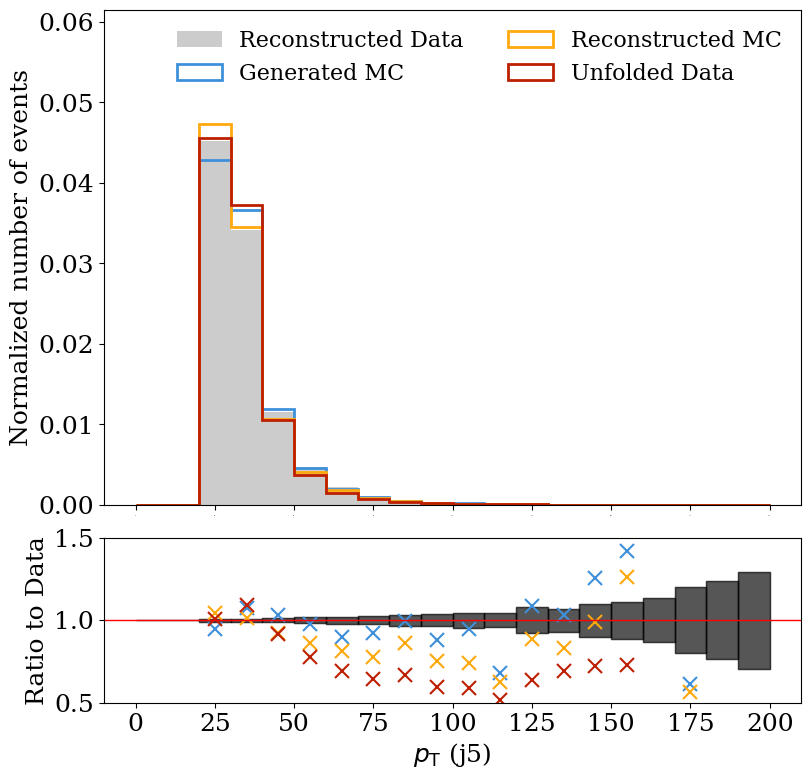

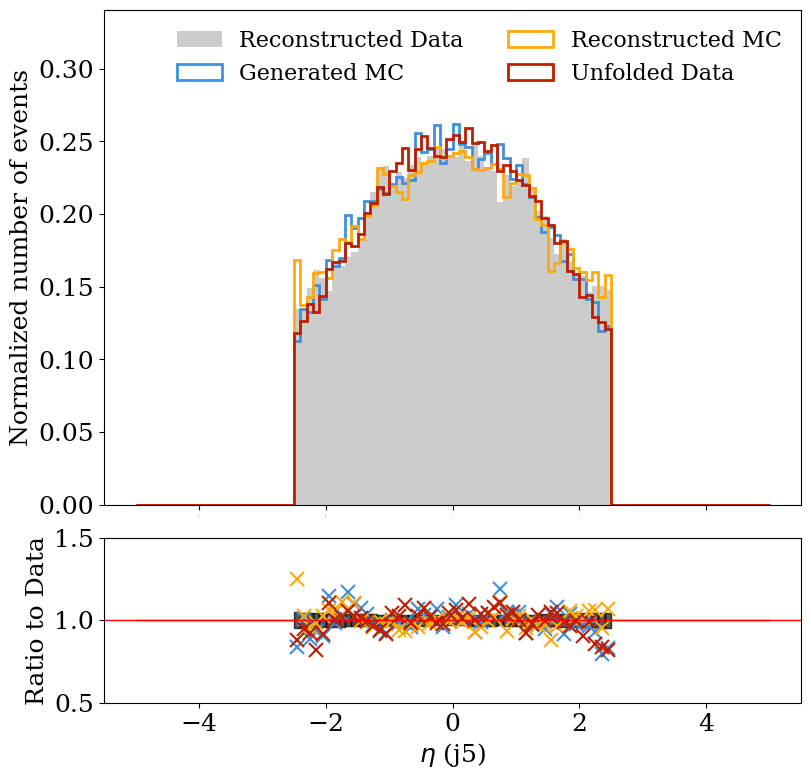

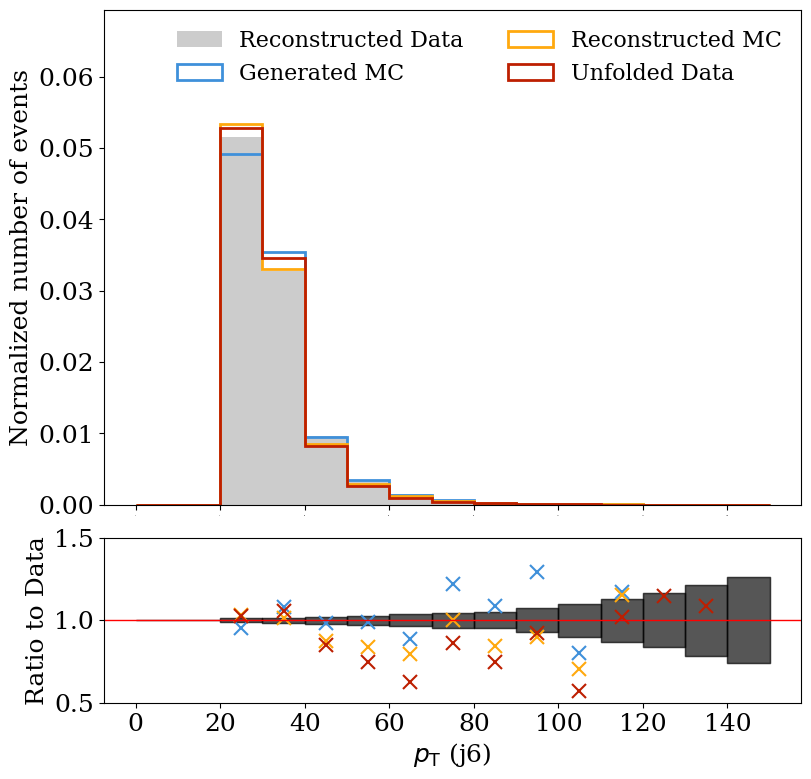

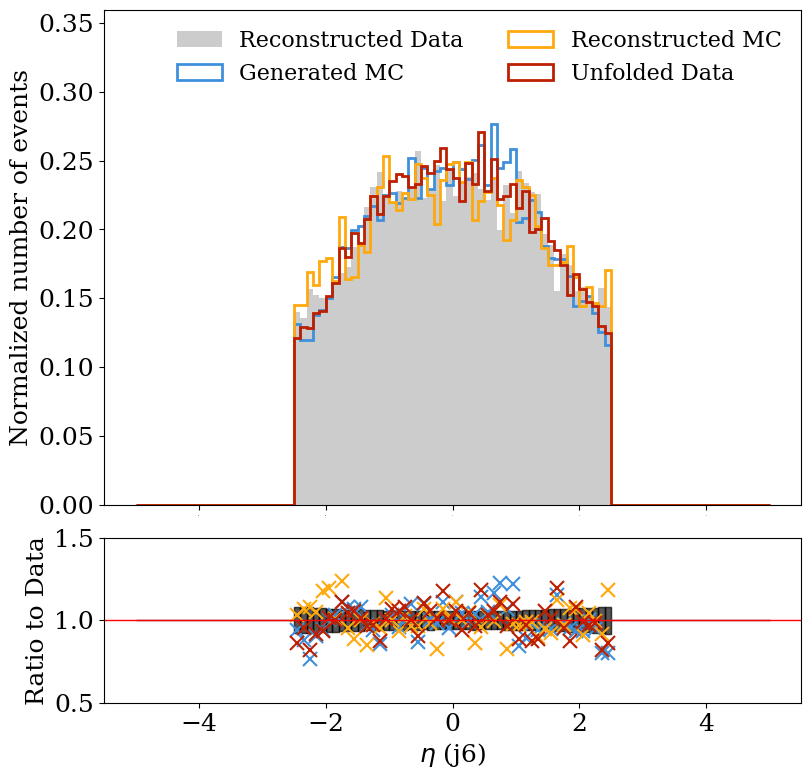

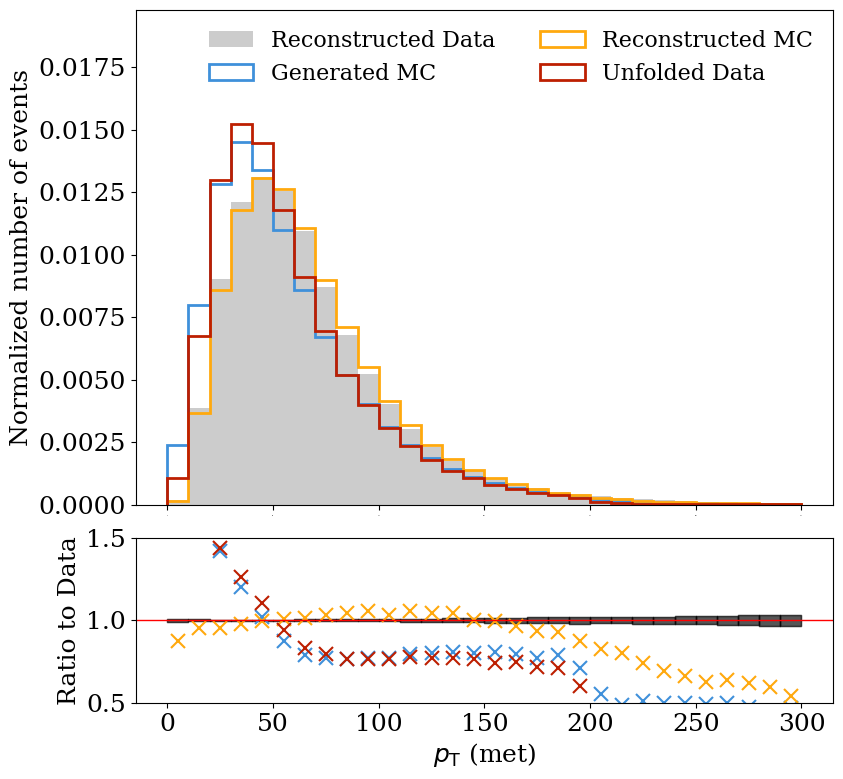

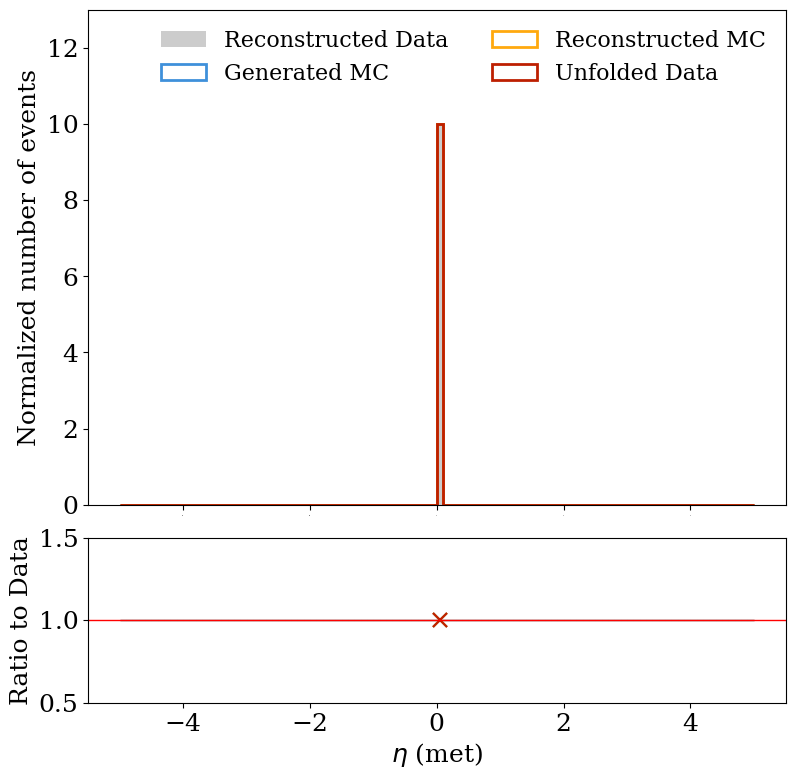

In [24]:
def compute_relative_bin_uncertainty(values, weights, binning):
    """
    Compute per-bin statistical uncertainties: sqrt(sum(w²)) / sum(w)
    
    Parameters:
        values: array of observable values per event (e.g., pt or eta)
        weights: array of weights per event (same shape as values)
        binning: array of bin edges
    
    Returns:
        relative_uncertainty: array of length (len(binning)-1)
    """
    # Histogram: sum of weights (Σw)
    sum_w, _ = np.histogram(values, bins=binning, weights=weights)
    
    # Histogram: sum of squared weights (Σw²)
    sum_w2, _ = np.histogram(values, bins=binning, weights=weights**2)
    
    # Compute relative uncertainty
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_uncertainty = np.sqrt(sum_w2) / sum_w
        rel_uncertainty[~np.isfinite(rel_uncertainty)] = 0  # Handle 0/0 and inf
    
    return rel_uncertainty

particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

pt_binning = {
    'l1': np.linspace(0, 300, 31),
    'b1': np.linspace(0, 400, 41),
    'b2': np.linspace(0, 300, 31),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 51),
    'j2': np.linspace(0, 400, 41),
    'j3': np.linspace(0, 300, 31),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}
default_binning = [
    None,  # placeholder for pt, unused
    np.linspace(-5, 5, 101),     # eta
]

labels = [
    r"$p_\mathrm{T}$",
    r"$\eta$",
]


for i, pname in enumerate(particles):
    for obs_index in range(2):  # 0: pT, 1: eta
        if obs_index == 0:
            bins = pt_binning[pname]
        else:
            bins = default_binning[obs_index]
        data_dict = {
            #'Truth Distribution': data_loader.gen[:, i, obs_index][herwig_loader.gen[:, i, 0]!=0],
            'Reconstructed Data': data_loader.reco[:, i, obs_index][data_loader.reco[:, i, 0]!=0],
            'Generated MC': pythia_loader.gen[:, i, obs_index][(pythia_loader.gen[:, i, 0]!=0)&flags_mc],
            'Reconstructed MC': pythia_loader.reco[:, i, obs_index][(pythia_loader.reco[:, i, 0]!=0)&flags_mc],
            'Unfolded Data': pythia_truth_test[:, i, obs_index][pythia_truth_test[:, i, 0]!=0],
        }

        weight_dict = {
            #'Truth Distribution': herwig_loader.weight[herwig_loader.gen[:, i, 0]!=0],
            'Reconstructed Data': data_loader.weight[data_loader.reco[:, i, 0]!=0],
            'Generated MC': pythia_loader.weight[(pythia_loader.gen[:, i, 0]!=0)&flags_mc],
            'Reconstructed MC': pythia_loader.weight[(pythia_loader.reco[:, i, 0]!=0)&flags_mc],
            'Unfolded Data': unfolded_weights[pythia_truth_test[:, i, 0]!=0]*pythia_weights_test[pythia_truth_test[:, i, 0]!=0],
        }

        relative_unc = compute_relative_bin_uncertainty(data_dict['Generated MC'], weight_dict['Generated MC'], bins)
        #scaled_rel_unc = relative_unc * total_SF
        #print(scaled_rel_unc)
        fig, _ = HistRoutine(
            data_dict,
            f"{labels[obs_index]} ({pname})",
            reference_name='Reconstructed Data',
            weights=weight_dict,
            plot_ratio=True,
            binning=bins,
            uncertainty= relative_unc
        )